In [70]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
def onemax(P, d):
    return np.sum(P, 1)

def deceptive_onemax(P, d):
    pop_size = len(P)
    res = np.zeros(pop_size)
    for i in range(pop_size):
        if np.count_nonzero(P[i]) > 0:
            res[i] = np.sum(P[i])
        else:
            res[i] = d + 1
    return res

def k_deceptive_onemax(P, d, k=5):
    N, d = P.shape
    s = np.zeros(N)
    for j in range(k, d + 1, k):
        tmp = P[:, j - k: j].sum(axis=1)
        tmp[tmp == 0] = k + 1
        s += tmp
    return s


https://faculty.cc.gatech.edu/~isbell/papers/isbell-mimic-nips-1997.pdf  




In [72]:
def binary_random(p):
    return int(np.random.rand() < p)

def random_individual(p, d):
    x = np.array([binary_random(p[i]) for i in np.arange(d)])
    return x

def random_population(p, N, d):
    P = np.array([random_individual(p,d) for _ in np.arange(N)])
    return P

$H(x) = -p \cdot {log_2}(p) - (1-p) \cdot log_2(1-p) $

In [73]:
class MIMIC:
    def __init__(self, N, obj_func, percentile, d, iters):
        self.d = d
        self.iters, self.N, self.obj_func, self.percentile = iters, N, obj_func, percentile
        self.p = np.array([0.5 for _ in range(d)])
        self.best_individuals = []
        self.best_vals = np.zeros(iters)
        self.worst_vals = np.zeros(iters)
        self.mean_vals = np.zeros(iters)
        self.probs = []
        self.P = None 
        self.eval_P = None
        self.theta = None
        self.sample = None

    def init_popu(self):
        self.P = random_population(self.p, self.N, self.d)
        self.eval_P = self.obj_func(self.P, self.d) * -1
        self.theta = np.percentile(self.eval_P, self.percentile)
        self.sample = self.P[self.eval_P <= self.theta]

    def entropy(self, X):
        p_one = np.count_nonzero(X) / (len(X) + 1e-10)
        p_zero = 1 - p_one
        return -(p_one * np.log2(p_one + 1e-10) + p_zero * np.log2(p_zero + 1e-10))

    def conditional_entropy(self, Y, X):
        p_one = np.count_nonzero(X) / (len(X) + 1e-10)
        p_zero = 1 - p_one
        indices_one = np.argwhere(X == 1).ravel()
        indices_zero = np.argwhere(X == 0).ravel()
        res = p_one * self.entropy(Y[indices_one]) + p_zero * self.entropy(Y[indices_zero])
        return res

    def update_prob(self):
        I = np.zeros(self.d, dtype=int)
        I[-1] = np.argmin([self.entropy(self.sample[:, k]) for k in range(self.d)])

        for i in range(self.d - 2, -1, -1):
            js = list(set(range(self.d)) - set(I[i + 1:]))
            best_j = np.argmin([self.conditional_entropy(self.sample[:, j], self.sample[:, I[i + 1]]) for j in js])
            I[i] = js[best_j]
            self.p[I[i]] = self.get_prob(self.sample[:, I[i]], self.sample[:, I[i + 1]])

        self.p[I[-1]] = self.get_prob(self.sample[:, I[-1]])

    def get_prob(self, X, Y=None):
        if Y is None:
            return np.count_nonzero(X) / len(X)
        else:
            return np.sum(np.logical_and(X, Y)) / (np.count_nonzero(Y) + 1e-100)

    def run(self, verbose=False):
        for i in range(self.iters):
            self.probs.append(self.p.copy())
            self.init_popu() 
            self.update_prob()

            self.best_individuals.append(self.P[np.argmin(self.eval_P)])
            self.best_vals[i] = np.min(self.eval_P)
            self.worst_vals[i] = np.max(self.eval_P)
            self.mean_vals[i] = np.mean(self.eval_P)

            if verbose and (i == 0 or i == self.iters - 1 or i % 50 == 0):
                print(self.best_vals[i], min(self.best_vals))

        return self.best_individuals[np.argmax(self.best_vals)], -self.best_vals, -self.worst_vals, -self.mean_vals, self.probs


In [74]:
def plot(func, P):
    fig, ax = plt.subplots(1, 2, figsize = (17, 5))
    fig.suptitle(func)
    T = len(P[1])
    ax[0].plot(np.arange(T), np.array(P[4]))
    ax[0].set_title('Probabilities')
    
    ax[1].plot(np.arange(T), P[1], label = 'Best scores')
    ax[1].plot(np.arange(T), P[2], label = 'Wrost scores')
    ax[1].plot(np.arange(T), P[3], label = 'Mean scores')
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('Cost function')
    plt.show()


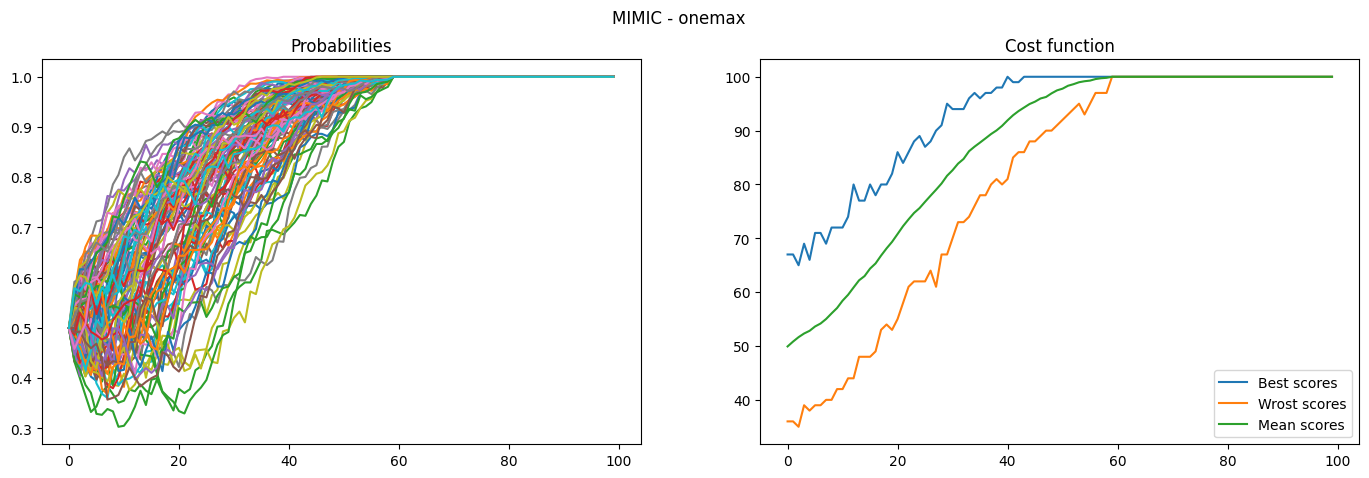

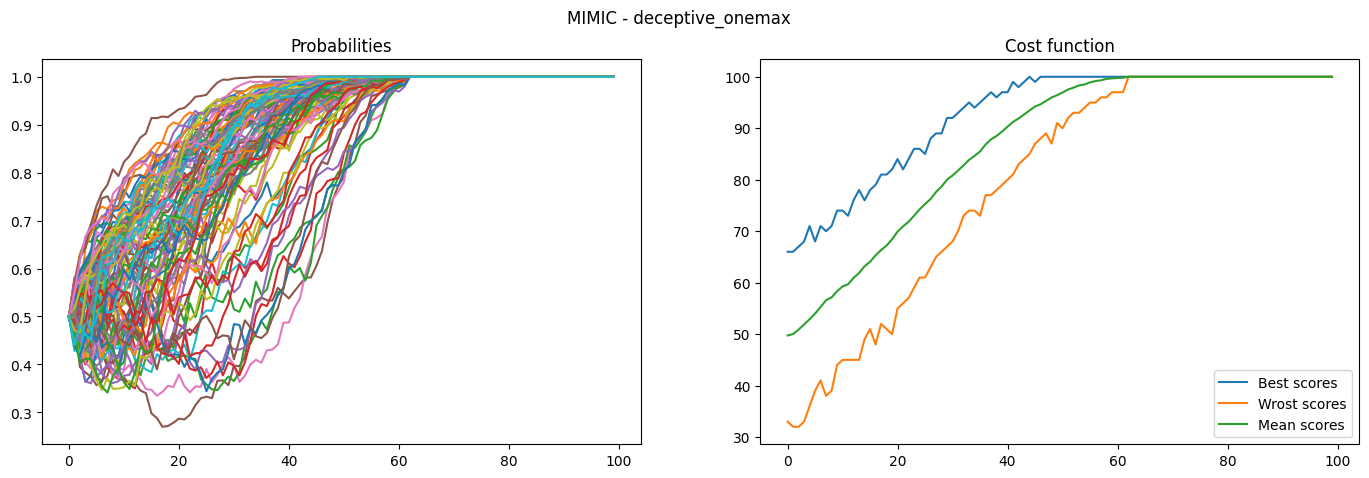

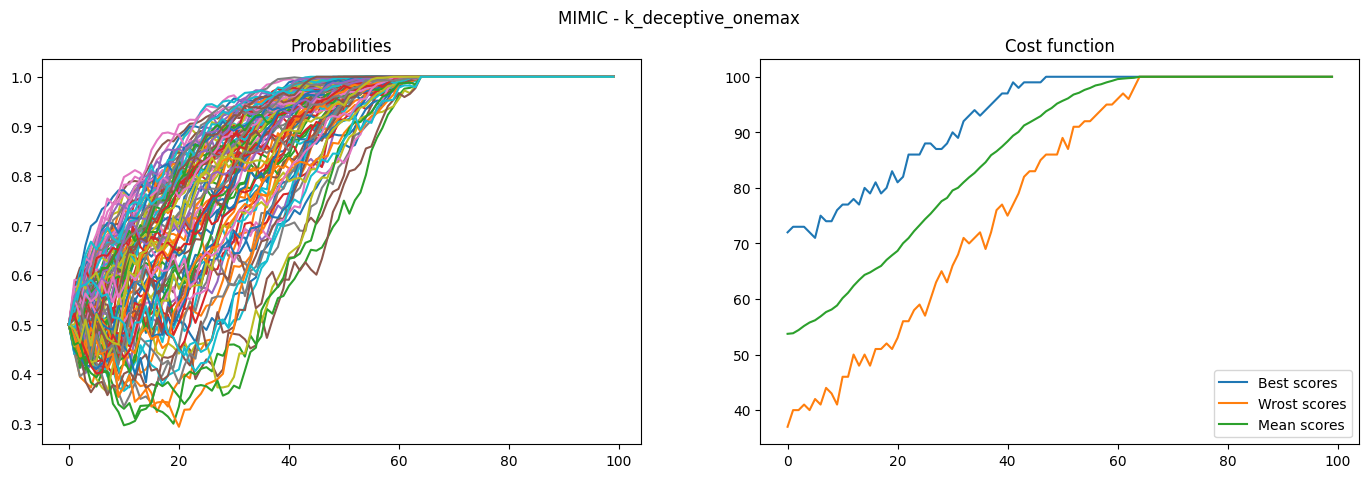

In [76]:
N =1000
d = 100
percentile = 80
iters=100
Func = [onemax, deceptive_onemax, k_deceptive_onemax]

for func in Func:
    mimic = MIMIC( N, obj_func = func, percentile = percentile, d = d, iters=iters)
    plot(f'MIMIC - {func.__name__}',mimic.run())
